In [2]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config=tf.ConfigProto()
config.gpu_options.visible_device_list = "3"
config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))

Using TensorFlow backend.


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]='3'
from __future__ import division
from __future__ import print_function
import matplotlib as mpl
import matplotlib.pyplot as plt
import multiresolutionimageinterface as mir
import numpy as np
import openslide
from scipy import ndimage as nd
from skimage import measure 
import math
import xml.etree.ElementTree as et
from PIL import Image, ImageDraw
from matplotlib.colors import hsv_to_rgb
from skimage.color import rgb2hsv
from skimage.color import hsv2rgb,rgb2gray
from skimage.filters import threshold_otsu
from glob import glob
import pickle
import argparse
import sys
import tensorflow as tf

In [4]:
NORMAL_SLIDES_DIR='/media/data/home/ysvang/Camelyon16/Train_Normal'
TUMOR_SLIDES_DIR='/media/data/home/ysvang/Camelyon16/Train_Tumor'
MASK_DIR='/media/data/home/ysvang/Camelyon16/Ground_Truth_Extracted/Mask'
ANNO_DIR='/media/data/home/ysvang/Camelyon16/Ground_Truth_Extracted/XML'

In [5]:
demo_slide_file='/media/data/home/ysvang/Camelyon16/Train_Tumor/Tumor_001.tif'
demo_anno_file='/media/data/home/ysvang/Camelyon16/Train_Tumor/Tumor_001.xml'
demo_mask_file='/media/data/home/ysvang/Camelyon16/Ground_Truth_Extracted/Mask/Tumor_001_Mask.tif'
# a region in demo slide that contains tumor
test_region_top_left=(68924,131761)
test_region_size=(5000,5000)

In [6]:
def coordinate_convert_with_jitter(slide,coordinate,level0,level1):
    '''Convert coordinate from level0 to level1. Because a pixel at a higher downsample level 
    may correspond to many pixels in the lower downsample level, so we randomly choose one 
    pixel in the lower downsample level.'''
    ds0=slide.level_downsamples[level0]
    ds1=slide.level_downsamples[level1]
    x=int(coordinate[0]*ds0/ds1)-np.random.randint(ds0/ds1)
    y=int(coordinate[1]*ds0/ds1)-np.random.randint(ds0/ds1)
    x=0 if x<0 else x
    y=0 if y<0 else y
    return x,y

In [7]:
def coordinate_convert(slide,coordinate,level0,level1):
    '''Convert coordinate from level0 to level1.'''
    ds0=slide.level_downsamples[level0]
    ds1=slide.level_downsamples[level1]
    return int(coordinate[0]*ds0/ds1),int(coordinate[1]*ds0/ds1)

In [8]:
def display_slide(slide_file,anno_file=None,display_topleft=(0,0),display_size=(299,299),level=0,border_thickness=150,fig_size=(15,10)):
    '''Given the slide file path and annotation(XML) file path(optional), display slide and optionally the tumor region. If the border of '''
    if anno_file:
        #parse XML file
        root=et.parse(anno_file).getroot()
        annotations_list=[]
        for annotation in root[0].findall('Annotation'):
            annotation_color=annotation.get('Color')
            coordinates=annotation.find('Coordinates')
            coordinates_list=[]
            for coordinate in coordinates:
                coordinates_list.append((float(coordinate.get('X')),float(coordinate.get('Y'))))
            annotations_list.append((annotation_color,coordinates_list))
    #print(annotations_list)
    with openslide.OpenSlide(slide_file)as slide:
    #     display_topleft=(71424,122261)
    #     display_size=(3200,3200)
        if type(display_size)==str and display_size=='full':
            display_size=slide.level_dimensions[0]
            display_topleft=(0,0)
        #ds=[slide.level_dimensions[0][i]/slide.level_dimensions[level][i] for i in xrange(2)]
        ds=[slide.level_downsamples[level]]*2
        whole_slide=slide.read_region(display_topleft,level,[int(display_size[i]/ds[i]) for i in range(2)])
        #the geometric mean of width and height of the crop
        average_len=math.sqrt(whole_slide.size[0]*whole_slide.size[1])
        if anno_file:
            #draw border on the image
            draw=ImageDraw.Draw(whole_slide)
            for anno in annotations_list:
                annotations_in_display=[((x-display_topleft[0])/ds[0],(y-display_topleft[1])/ds[1]) \
                                        for x,y in anno[1] \
                                        if 0<=x-display_topleft[0]<=display_size[0] and 0<=y-display_topleft[1]<=display_size[1]]

                #draw.line(annotations_in_display,width=10,fill='blue')
                #[draw.ellipse([x,y,x+border_thickness/ds[0],y+border_thickness/ds[1]],fill=anno[0]) for x,y in annotations_in_display ]
                [draw.ellipse([x,y,x+border_thickness*average_len/1000,y+border_thickness*average_len/1000],fill=anno[0]) for x,y in annotations_in_display ]
        plt.imshow(whole_slide,aspect='equal')
        plt.gcf().set_size_inches(fig_size)


In [13]:
with openslide.OpenSlide(slide_file) as f:
    print(f.level_dimensions[0])

(94208, 71680)


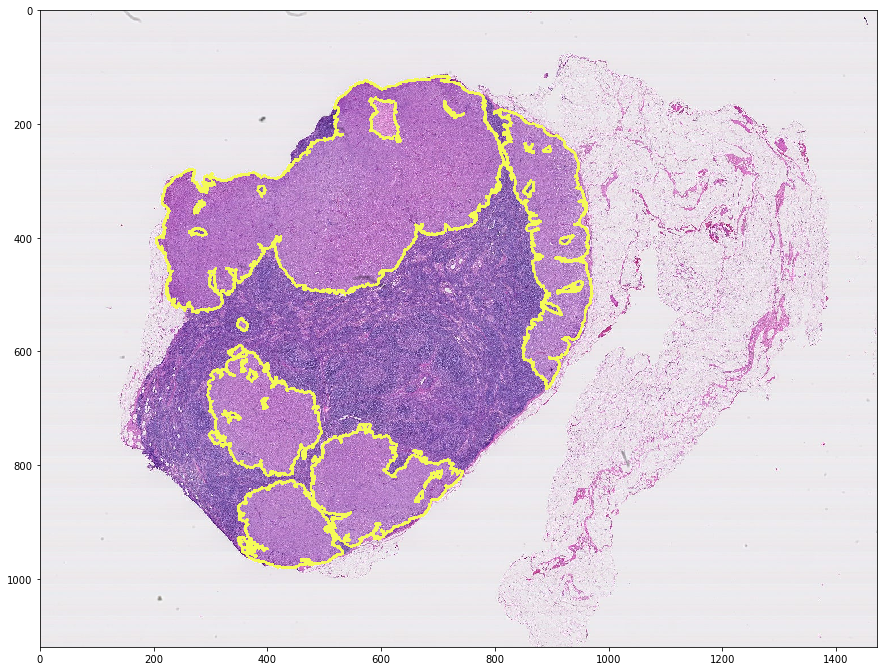

In [30]:
slide_file='/media/data/home/ysvang/Camelyon16/Train_Tumor/Tumor_110.tif'
anno_file='/media/data/home/ysvang/Camelyon16/Train_Tumor/Tumor_110.xml'

display_slide(slide_file,anno_file,display_topleft=(22000,18000),display_size='full',border_thickness=3,level=6,fig_size=(15,12))
plt.show()

In [20]:
def patch_check(image):
    '''Use R>G |B>G as a criteria to distinguish between empty patch or tissue patch'''
    percent=np.mean((image[:,:,0]>image[:,:,1])|(image[:,:,2]>image[:,:,1]))
    return percent

In [21]:
def tumor_patch_check(tumor_mask,patch_topleft,patch_size,center_size=(128,128)):
    '''According to tumor mask file, determine the percentage of tumor pixels in the center region(default:128x128) of the patch'''
    delta_x=(patch_size[0]-center_size[0])/2
    delta_y=(patch_size[1]-center_size[1])/2
    return np.mean(tumor_mask.getUCharPatch(int(patch_topleft[0]+delta_x),int(patch_topleft[1]+delta_y),center_size[0],center_size[1],0).reshape(*center_size))/255
    

In [22]:
#Because loading the whole slide at level0 is impossible(not enough memory), we need to load whole slide
#at a downsampled level(called guide_level), and then do the whole slide threshold
GUIDE_LEVEL=3
def sample_from_normal_slide(slide_file,num_of_patches,patch_size=(299,299)):
    with openslide.OpenSlide(slide_file) as slide:  
        normal_random_crops=[]
        whole_image=np.array(slide.read_region((0,0),GUIDE_LEVEL,slide.level_dimensions[GUIDE_LEVEL]))[:,:,:3]
# RGB threshold
#         threshold1=whole_image_level3[:,:,0]<threshold_otsu(whole_image_level3[:,:,0])
#         threshold2=whole_image_level3[:,:,1]<threshold_otsu(whole_image_level3[:,:,1])
#         threshold3=whole_image_level3[:,:,2]<threshold_otsu(whole_image_level3[:,:,2])
        #Grey 0.8 threshold
        whole_image_grey=rgb2gray(whole_image)
        #get the pixels that passed the threshold
        possible_y,possible_x=np.nonzero(whole_image_grey<0.8)
        while len(normal_random_crops)<num_of_patches:
            rand=np.random.randint(len(possible_x))
            #need to convert from a lower level to a higher level
            selected_x,selected_y=coordinate_convert_with_jitter(slide,(possible_x[rand],possible_y[rand]),GUIDE_LEVEL,0)        
            if selected_x+patch_size[0] < slide.level_dimensions[0][0] and selected_y+patch_size[1]<slide.level_dimensions[0][1]:
                img=np.array(slide.read_region((selected_x,selected_y),0,(patch_size)))[:,:,:3]
                #patch_check_score= patch_check(img)
                #mean_value=img.mean(axis=(0,1))
                #if patch_check_score>0.99 and mean_value[0]>70 and mean_value[2]>70: #adjustable
                normal_random_crops.append(img)
        return normal_random_crops

In [43]:
def preprocess_mask_file(mask_file,step_size=40000):
    '''Get the indices of tumor pixels'''
    tumor_index=[]
    reader = mir.MultiResolutionImageReader()
    mr_image = reader.open(mask_file)
    tix_list=[]
    tiy_list=[]
    try:      
        #mask_arr=np.array(mask.read_region((0,0),0,mask.level_dimensions[0]))
        #We need to extract the tumor pixels step by step, because loading the entire mask file is impossible(out of memory)
        for i in xrange(0,mr_image.getLevelDimensions(0)[0],step_size):
            for j in xrange(0,mr_image.getLevelDimensions(0)[1],step_size):
                next_step_x=min(step_size,mr_image.getLevelDimensions(0)[0]-i)
                next_step_y=min(step_size,mr_image.getLevelDimensions(0)[1]-j)               
                region=mr_image.getUCharPatch(i, j, next_step_x, next_step_y, 0).reshape(next_step_y,next_step_x)
                tiy,tix=np.nonzero(region)
                tix_list.append(tix+i)
                tiy_list.append(tiy+j)
        tumor_index=(np.hstack(tix_list),np.hstack(tiy_list))
        return tumor_index
    finally:
        mr_image.close()

In [47]:
def sample_tumor_patch_from_tumor_slide(slide_file,mask_file,tumor_index,num_of_patches,patch_size=(299,299)):
    with openslide.OpenSlide(slide_file) as slide:
        tumor_random_crops=[]
        reader = mir.MultiResolutionImageReader()
        mr_image = reader.open(mask_file)
        tumor_x_list,tumor_y_list=tumor_index
        assert len(tumor_x_list)==len(tumor_y_list)
        try:
            while len(tumor_random_crops)<num_of_patches:
                rand=np.random.randint(len(tumor_x_list))
                selected_x,selected_y=tumor_x_list[rand],tumor_y_list[rand]
                if selected_x+patch_size[0] < slide.level_dimensions[0][0] and selected_y+patch_size[1]<slide.level_dimensions[0][1]:
                    img=np.array(slide.read_region((selected_x,selected_y),0,(patch_size)))[:,:,:3]
                    #patch_check_score=patch_check(img)
                    tumor_patch_check_score=tumor_patch_check(mr_image,(selected_x,selected_y),patch_size)
                    if tumor_patch_check_score>0: #adjustable
                        tumor_random_crops.append(img)
            return tumor_random_crops
        finally:
            mr_image.close()

In [25]:
GUIDE_LEVEL=3
def sample_normal_patch_from_tumor_slide(slide_file,mask_file,num_of_patches,patch_size=(299,299)):
    with openslide.OpenSlide(slide_file) as slide:
        reader = mir.MultiResolutionImageReader()
        mr_image = reader.open(mask_file)
        normal_random_crops=[]
        try:            
            whole_image=np.array(slide.read_region((0,0),GUIDE_LEVEL,slide.level_dimensions[GUIDE_LEVEL]))[:,:,:3]
            #RGB threshold
#             threshold1=whole_image_level4[:,:,0]<threshold_otsu(whole_image_level4[:,:,0])
#             threshold2=whole_image_level4[:,:,1]<threshold_otsu(whole_image_level4[:,:,1])
#             threshold3=whole_image_level4[:,:,2]<threshold_otsu(whole_image_level4[:,:,2])
            whole_image_grey=rgb2gray(whole_image)
            possible_y,possible_x=np.nonzero(whole_image_grey<0.8)
            while len(normal_random_crops)<num_of_patches:
                rand=np.random.randint(len(possible_x))
                selected_x,selected_y=coordinate_convert_with_jitter(slide,(possible_x[rand],possible_y[rand]),GUIDE_LEVEL,0)
                #print(type(selected_x),type(patch_size),type(slide.level_dimensions),type(selected_y))
                
                if selected_x+patch_size[0] < slide.level_dimensions[0][0] and selected_y+patch_size[1]<slide.level_dimensions[0][1]:
                    img=np.array(slide.read_region((selected_x,selected_y),0,(patch_size)))[:,:,:3]
#                     patch_check_score=patch_check(img)
                    tumor_patch_check_score=tumor_patch_check(mr_image,(selected_x,selected_y),patch_size)
#                     mean_value=img.mean(axis=(0,1))
                    if tumor_patch_check_score<0.0001 : #adjustable
                        normal_random_crops.append(img)
            return normal_random_crops
        finally:
            mr_image.close()

In [73]:
def data_augmentation(data):
    '''Data augmentation according to Google paper'''
    data_augmented=[]
    with tf.Session() as sess:
        augmentation=[]
        image=tf.placeholder(tf.uint8,name='image')
        augmentation.append(image)
        augmentation+=[tf.image.rot90(image,k=i) for i in xrange(1,4)]
        image_flipped=tf.image.flip_left_right(image)
        augmentation.append(image_flipped)
        augmentation+=[tf.image.rot90(image_flipped,k=i) for i in xrange(1,4)]
        for d in data:
            data_augmented+=sess.run(augmentation,feed_dict={image:d})
        return data_augmented
        
        

In [111]:
parser=argparse.ArgumentParser()
parser.add_argument('-m',dest='mode',required=True)
parser.add_argument('-s',dest='slide_file',required=True)
parser.add_argument('-b',dest='mask_file')
parser.add_argument('-n',dest='patch_number_before_augmentation',type=int,required=True)
parser.add_argument('-a',dest='augmentation',action='store_true')
parser.add_argument('-o',dest='output_file',required=True)
args=parser.parse_args()

In [110]:
if args.mode=='normal_from_normal':        
    patches=sample_from_normal_slide(args.slide_file,args.patch_number_before_augmentation)
    if args.augmentation:
        patches=data_augmentation(patches)
    np.save(args.output_file,patches)
elif args.mode=='normal_from_tumor':
    if not args.mask_file:
        raise ValueError('need mask file')
    patches=sample_normal_patch_from_tumor_slide(args.slide_file,args.mask_file,args.patch_number_before_augmentation)
    if args.augmentation:
        patches=data_augmentation(patches)
    np.save(args.output_file,patches)
elif args.mode=='tumor_from_tumor':
    if not args.mask_file:
        raise ValueError('need mask file')
    tumor_index=preprocess_mask_file(args.mask_file)
    patches=sample_tumor_patch_from_tumor_slide(args.slide_file,args.mask_file,tumor_index,args.patch_number_before_augmentation)
    if args.augmentation:
        patches=data_augmentation(patches)
    np.save(args.output_file,patches)
else:
    raise ValueError('No such mode "%s" '%args.mode)

AttributeError: 'Namespace' object has no attribute 'patch_number'

In [90]:
# for i in xrange(5):
#     plt.subplot(1,5,i+1)
#     plt.axis('off')
#     plt.imshow(normal_from_tumor[i][0])
# plt.gcf().set_size_inches((20,12))
# plt.show()

In [51]:
# for i in xrange(5):
#     plt.subplot(1,5,i+1)
#     plt.axis('off')
#     plt.imshow(tumor_from_tumor[i])
# plt.gcf().set_size_inches((20,12))
# plt.show()

In [92]:
# with openslide.OpenSlide(demo_slide_file) as slide:
#     whole_image_level7=np.array(slide.read_region((0,0),7,slide.level_dimensions[7]))[:,:,:3]
#     plt.subplot(2,2,1)
#     plt.title('Original')
#     plt.imshow(whole_image_level7)
#     plt.subplot(2,2,2)
#     plt.title('Red channel otsu')
#     threshold1=whole_image_level7[:,:,0]>threshold_otsu(whole_image_level7[:,:,0])
#     plt.imshow(threshold1,cmap='Greys')
#     plt.subplot(2,2,3)
#     plt.title('Green channel otsu')
#     threshold2=whole_image_level7[:,:,1]>threshold_otsu(whole_image_level7[:,:,1])
#     plt.imshow(threshold2,cmap='Greys')
#     plt.subplot(2,2,4)
#     plt.title('Blue channel otsu')
#     threshold3=whole_image_level7[:,:,2]>threshold_otsu(whole_image_level7[:,:,2])
#     plt.imshow(threshold3,cmap='Greys')
#     plt.gcf().set_size_inches(20,15)
#     plt.figure()
#     plt.subplot(2,2,1)
#     plt.title('R&G&B')
#     plt.imshow(np.logical_not(threshold1&threshold2&threshold3),cmap='Greys')
#     plt.subplot(2,2,2)
#     plt.title('H channel otsu')
#     whole_image_level7_hsv=rgb2hsv(whole_image_level7)
#     threshold4=whole_image_level7_hsv[:,:,0]>threshold_otsu(whole_image_level7_hsv[:,:,0])
#     plt.imshow(threshold4,cmap='Greys')
#     plt.subplot(2,2,3)
#     plt.title('S channel otsu')
#     threshold5=whole_image_level7_hsv[:,:,1]>threshold_otsu(whole_image_level7_hsv[:,:,1])
#     plt.imshow(threshold5,cmap='Greys')
#     plt.subplot(2,2,4)
#     plt.title('H&S channel otsu')
#     threshold6=whole_image_level7_hsv[:,:,2]>threshold_otsu(whole_image_level7_hsv[:,:,2])
#     plt.imshow(threshold4&threshold5,cmap='Greys')
#     plt.gcf().set_size_inches(20,15)
#     plt.figure()
#     whole_image_level7_gray=rgb2gray(whole_image_level7)
#     threshold7=whole_image_level7_gray<0.8
#     plt.title('Grey 0.8')
#     plt.imshow(threshold7,cmap='Greys')
#     plt.gcf().set_size_inches((5,7))
#     plt.show()


In [289]:
# with openslide.OpenSlide('/media/data/home/ysvang/Camelyon16/Train_Tumor/Tumor_001.tif') as slide:
#     print(slide.level_downsamples)
#     print(slide.level_dimensions)
#     print(slide.dimensions)
#     print(slide.get_best_level_for_downsample(0))
#     level=1
#     top_left=(68924,131761)
#     level0size=(5000,5000)
#     ds=[slide.level_dimensions[0][i]/slide.level_dimensions[level][i] for i in xrange(2)]
#     region=slide.read_region(top_left,level,(int(level0size[0]/ds[0]),int(level0size[1]/ds[1])))
#     plt.imshow(region,aspect='equal')
#     plt.gcf().set_size_inches(8, 12)
#     plt.show()